# FORMATIVE ASSESSMENT OF ADOLESCENT GIRLS AND YOUNG WOMEN’S HIV, GENDER-BASED VIOLENCE AND SEXUAL AND REPRODUCTIVE HEALTH STATUS

## Background
Teenage pregnancy and motherhood have been a major health and social concern in Uganda as it infringes upon the human rights of girls but also hinders their ability to achieve their full socioeconomic development. Teenagers who engage in sexual intercourse at a young age face an elevated risk of becoming pregnant and giving birth. The 2022 UDHS indicated that 23.5% of women age 15-19 had initiated childbearing by the time of the survey, with 18.4% having already had a live birth, while 5.1% were pregnant with their first child.

Patterns by background characteristics:
* By age 16, 1 in every 10 women age 15-19 has begun childbearing. This percentage significantly rises to almost 4 out of every 10 by the time they reach 18 (Table 5.12).
* Teenagers in rural areas started childbearing earlier than those in urban areas. Twenty five percent of women age 15-19 in rural areas have begun childbearing, compared with 21% in urban areas.
* Teenage childbearing varies by region. The percentage of women age 15-19 who have begun childbearing ranges from 15% in Kigezi region to 28 % -30% in Busoga and Bukedi sub regions.
* The proportion of women age 15-19 who have begun childbearing decreases with both education and wealth.

Regions: The selection of the districts that we surveyed was informed by HIV prevalence dynamics and implementing partner support: we went to districts where there were Global Fund-supported implementing partners working to reduce the new number of new HIV infections among AGYW, improve SRH (e.g. reduce teenage pregnancy) and GBV indicators in the targeted districts.

## Data Analysis

The output of this notebook includes a data analysis responding to the research questions.

### Set Environment and Load Data

In [3]:
# Libraries
import warnings
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from spicy import stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from matplotlib.ticker import PercentFormatter

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/teenage_pregnancy')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/teenage_pregnancy


In [4]:
# Load the data
df_raw = pd.read_csv("./data/processed_df.csv")

### Functions

In [6]:
def fit_and_summarize_logit(y, X0, X1, model_names=("Model 0", "Model 1")):
    """
    Fits two logistic regression models and prints summaries and ORs.

    Parameters:
    - y: pandas Series, binary outcome (0/1)
    - X0: pandas DataFrame, predictors for unadjusted model
    - X1: pandas DataFrame, predictors for adjusted model
    - model_names: tuple of two strings for printing model titles

    Returns:
    - model0, model1: fitted statsmodels Logit results
    """
    # Ensure numeric and add constant
    X0 = sm.add_constant(X0.astype(float))
    X1 = sm.add_constant(X1.astype(float))
    y0 = y.astype(int)

    # Fit Model 0
    model0 = sm.Logit(y0, X0).fit(disp=False)
    print(f"=== {model_names[0]} ===")
    print(model0.summary())
    print("\nOdds Ratios (Unadjusted):\n", np.exp(model0.params))

    # Fit Model 1
    model1 = sm.Logit(y0, X1).fit(disp=False)
    print(f"\n=== {model_names[1]} ===")
    print(model1.summary())
    print("\nAdjusted Odds Ratios:\n", np.exp(model1.params))

    return model0, model1

In [7]:
def plot_stacked_proportions(
    df,
    category_var,
    outcome_var,
    order,
    category_labels=None,
    outcome_labels=["No", "Yes"],
    colors=["lightblue", "salmon"],
    title="",
    ylabel="Percentage of Adolescents",
    legend_title="Outcome",
    save_path=None,
    figsize=(6,4),
    legend_loc=('lower center', (1.1, 0.4)),
    rotate_xticks=45
):
    """
    Plots a 100% stacked bar chart of outcome proportions by category.

    Parameters:
    - df: pandas DataFrame
    - category_var: str, name of categorical variable (e.g. 'wealth_tertile')
    - outcome_var: str, name of binary outcome (0/1)
    - order: list of category levels in desired order
    - category_labels: list of labels for x-axis; if None, uses `order`
    - outcome_labels: list of two labels for stacked segments [no, yes]
    - colors: list of two colors for segments [no, yes]
    - title: str, chart title
    - ylabel: str, y-axis label
    - legend_title: str, title for the legend
    - save_path: optional str, file path to save the PNG
    - figsize: tuple, figure size
    - legend_loc: tuple (loc, bbox_to_anchor) for legend placement
    - rotate_xticks: int, rotation angle for x-tick labels
    """
    # Compute counts and proportions
    counts = pd.crosstab(df[category_var], df[outcome_var]).reindex(order)
    props = counts.div(counts.sum(axis=1), axis=0)

    fig, ax = plt.subplots(figsize=figsize)
    props.plot(
        kind='bar',
        stacked=True,
        color=colors,
        ax=ax
    )

    # Y-axis formatting
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_yticks([i/5 for i in range(6)])  # 0.0 to 1.0 in steps of 0.2

    # X-axis labels
    labels = category_labels if category_labels is not None else order
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels(labels, rotation=rotate_xticks)

    # Axis labels and title
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.set_title(title, fontweight='bold', fontsize=12)

    # Remove grid and spines
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    ax.grid(False)

    # Legend
    loc, bbox = legend_loc
    ax.legend(
        outcome_labels,
        title=legend_title,
        frameon=False,
        loc=loc,
        bbox_to_anchor=bbox
    )

    # Annotate counts inside bars
    for idx, level in enumerate(order):
        cum = 0
        for col in counts.columns:
            height = props.loc[level, col]
            count = counts.loc[level, col]
            ax.text(
                idx,
                cum + height/2,
                str(count),
                ha='center',
                va='center'
            )
            cum += height

    plt.tight_layout()
    filepath = save_path.format(title=title.replace(" ", "_"))
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    plt.savefig(filepath, dpi=300)
    plt.show()

In [8]:
def plot_significant_forest(
    model,
    alpha=0.05,
    title=None,
    save_path="./results/{title}.png",
    var_labels=None,
    include_const=False
):
    """
    Plots a forest plot of odds ratios for statistically significant predictors
    from a statsmodels Logit/GLM result and saves the figure.

    Parameters:
    - model: statsmodels result object (e.g., from Logit.fit())
    - alpha: significance level for filtering predictors (default 0.05)
    - title: optional string for the plot title
    - save_path: a path template, with '{title}' placeholder, to save the plot
    - var_labels: dict mapping model parameter names to display labels
    - include_const: bool, whether to include the constant ('const') in the plot
    """
    # Extract parameters, p-values, and confidence intervals
    params = model.params.copy()
    pvalues = model.pvalues.copy()
    conf = model.conf_int().copy()

    # Optionally drop constant
    if not include_const:
        params = params.drop('const', errors='ignore')
        pvalues = pvalues.drop('const', errors='ignore')
        conf = conf.drop('const', errors='ignore')

    # Filter to statistically significant predictors
    signif = pvalues[pvalues < alpha].index.tolist()
    if not signif:
        print(f"No predictors are significant at alpha = {alpha}")
        return

    # Prepare arrays for plotting
    variables = signif
    coef = params.loc[variables].values
    ci_lower = conf.loc[variables, 0].values
    ci_upper = conf.loc[variables, 1].values

    # Convert to odds ratio scale
    or_vals = np.exp(coef)
    or_lower = np.exp(ci_lower)
    or_upper = np.exp(ci_upper)

    # Map variable names to display labels
    if var_labels:
        display_names = [var_labels.get(var, var) for var in variables]
    else:
        display_names = variables

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, max(4, 0.5 * len(variables) + 1)))
    y_pos = np.arange(len(variables))

    ax.errorbar(
        or_vals, y_pos,
        xerr=[or_vals - or_lower, or_upper - or_vals],
        fmt='o', capsize=4
    )
    ax.axvline(1, linestyle='--', color='grey')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(display_names)
    ax.set_xlabel("Odds Ratio (95% CI)")

    if title:
        ax.set_title(title, pad=10, fontsize=12, fontweight='bold')
    plt.tight_layout()

    # Save to file
    filepath = save_path.format(title=title.replace(" ", "_"))
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    plt.savefig(filepath, dpi=300)
    plt.show()

## 1. Wealth and Teenage Pregnancy

**How does household wealth predict the likelihood of teenage pregnancy?**

**Sample:**  
- Cases: Girls who experienced pregnancy between ages 10–19 = 1,925  
- Controls: Girls who never got pregnant and are now ≥ 20 = 1,513  

**=== M0: Unadjusted Effect ===**  
- **Low vs. High wealth:** OR = 9.29 (95% CI: exp[2.039, 2.419] ≈ [7.69, 11.23], p < 0.001)  
- **Medium vs. High wealth:** OR = 4.23 (95% CI: [3.53, 5.06], p < 0.001)  
- **Pseudo‑R²:** 0.133 (13% of variance explained)  

> Girls in the lowest wealth tertile have about 9.3 times the odds of a teen pregnancy compared to their highest‑wealth peers; those in the middle tertile have about 4.2 times the odds.  

**=== M1: Adjusted Effect ===**  
- **Low vs. High wealth:** OR = 5.73 (95% CI: [4.67, 7.21], p < 0.001)  
- **Medium vs. High wealth:** OR = 3.10 (95% CI: [2.48, 3.87], p < 0.001)  
- **Age (per year):** OR = 0.76 (95% CI: [0.72, 0.81], p < 0.001)  
- **Ever married vs. never:** OR = 39.29 (95% CI: [29.72, 51.93], p < 0.001)  
- **Pseudo‑R²:** 0.388 (39% of variance explained)  

> After adjusting for age and marital status, the wealth gradient remains strong: low‑wealth girls still have nearly sixfold higher odds of teen pregnancy, and each additional year of age reduces odds by about 24%.

In [10]:
# Sample
df = df_raw.loc[
    ((df_raw['been_preg'] == 1) & (df_raw['age_preg'] <= 19)) |
    ((df_raw['been_preg'] == 0) & (df_raw['age_completed'] >= 20))
].copy()

# Process features (dropna, create dummies)
df = df.dropna(subset=['been_preg', 'wealth_tertile', 'age_completed', 'been_married_binary'])
wealth_dummies = pd.get_dummies(df['wealth_tertile'], prefix='wealth', drop_first=True)

# Model
y = df['been_preg']
X0 = wealth_dummies
X1 = pd.concat([wealth_dummies, df[['age_completed','been_married_binary']]], axis=1)
m0, m1 = fit_and_summarize_logit(y, X0, X1, 
                                 model_names=("M0: Unadjusted Effect", "M1: Adjusted Effect"))

=== M0: Unadjusted Effect ===
                           Logit Regression Results                           
Dep. Variable:              been_preg   No. Observations:                 3438
Model:                          Logit   Df Residuals:                     3435
Method:                           MLE   Df Model:                            2
Date:                Tue, 06 May 2025   Pseudo R-squ.:                  0.1326
Time:                        18:00:08   Log-Likelihood:                -2045.6
converged:                       True   LL-Null:                       -2358.3
Covariance Type:            nonrobust   LLR p-value:                1.543e-136
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0240      0.070    -14.644      0.000      -1.161      -0.887
wealth_Low        2.2290      0.097     22.988      0.000       2.039       2.419
wealth_Med

### Visualisations

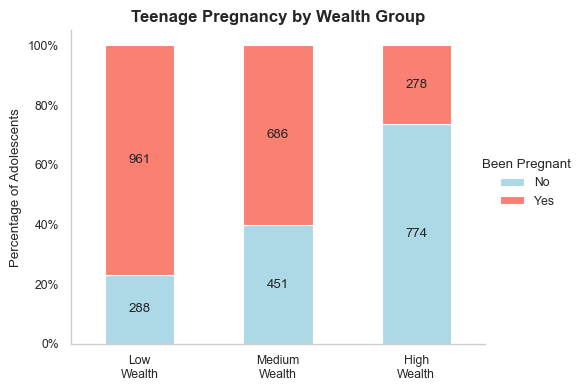

In [12]:
# M0
plot_stacked_proportions(
    df=df,
    category_var='wealth_tertile',
    outcome_var='been_preg',
    order=['Low','Medium','High'],
    category_labels=['Low\nWealth','Medium\nWealth','High\nWealth'],
    rotate_xticks=0,
    outcome_labels=['No','Yes'],
    legend_title='Been Pregnant',
    title='Teenage Pregnancy by Wealth Group',
    save_path='./results/{title}.png'
)

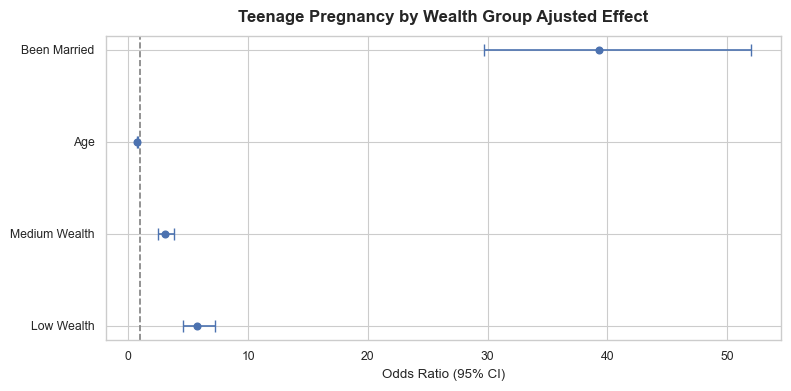

In [13]:
# M1
var_labels = {
    'wealth_Low': 'Low Wealth',
    'wealth_Medium': 'Medium Wealth',
    'age_completed' : 'Age',
    'been_married_binary' : 'Been Married'
}

plot_significant_forest(
    m1,
    alpha=0.05,
    title="Teenage Pregnancy by Wealth Group Ajusted Effect",
    var_labels=var_labels,
    include_const=False,
    save_path="./results/{title}.png"
)

## 2. Marriage and Teenage Pregnancy

**What is the effect of early marriage on pregnancy outcomes among teenage girls?**

**Sample:**  
- Cases: Girls with pregnancy ≤ 19 = 1,925  
- Controls: Girls never pregnant and now ≥ 20 = 1,513  

**=== M0: Unadjusted Effect ===**  
- **Married before vs. never/after:** OR = 56.24 (95% CI: exp[3.599, 4.460] ≈ [36.6, 86.5], p < 0.001)  
- **Pseudo‑R²:** 0.225 (23% of variance explained)  

> Adolescents who married before their first pregnancy have over 56 times the odds of a teen pregnancy compared to those who never married (or married after).  

**=== M1: Adjusted Effect ===**  
- **Married before vs. never/after:** OR = 51.39 (95% CI: exp[3.500, 4.379] ≈ [33.1, 79.6], p < 0.001)  
- **Low vs. High wealth:** OR = 7.20 (95% CI: [5.81, 8.96], p < 0.001)  
- **Medium vs. High wealth:** OR = 3.52 (95% CI: [2.86, 4.30], p < 0.001)  
- **Age (per year):** OR = 0.86 (95% CI: [0.82, 0.90], p < 0.001)  
- **Pseudo‑R²:** 0.311 (31% of variance explained)  

> Even controlling for wealth and age, marrying before one’s first pregnancy increases the odds of teen pregnancy by about 51 times.

In [15]:
# Sample
df = df_raw.loc[
    ((df_raw['been_preg'] == 1) & (df_raw['age_preg'] <= 19)) |
    ((df_raw['been_preg'] == 0) & (df_raw['age_completed'] >= 20))
].copy()

# Collapse 'after' into 'never' so we only need one dummy
df['marriage_timing2'] = df['marriage_timing'].replace({'after': 'never'})

# Process features (dropna, create dummies)
df = df.dropna(subset=['been_preg', 'marriage_timing', 'wealth_tertile', 'age_completed'])
mt_dummies = pd.get_dummies(df['marriage_timing2'], prefix='mt', drop_first=False)
mt_before = mt_dummies['mt_before']  # 1 if married before pregnancy, 0 otherwise
wealth_dummies = pd.get_dummies(df['wealth_tertile'], prefix='wealth', drop_first=True)

# Model
y = df['been_preg']
X0 = pd.DataFrame({'mt_before': mt_before})
X1 = pd.concat([mt_before, wealth_dummies, df['age_completed']], axis=1)
m0, m1 = fit_and_summarize_logit(y, X0, X1, 
                                 model_names=("M0: Unadjusted Effect", "M1: Adjusted Effect"))

=== M0: Unadjusted Effect ===
                           Logit Regression Results                           
Dep. Variable:              been_preg   No. Observations:                 3438
Model:                          Logit   Df Residuals:                     3436
Method:                           MLE   Df Model:                            1
Date:                Tue, 06 May 2025   Pseudo R-squ.:                  0.2249
Time:                        18:00:09   Log-Likelihood:                -1827.8
converged:                       True   LL-Null:                       -2358.3
Covariance Type:            nonrobust   LLR p-value:                1.041e-232
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3488      0.040     -8.661      0.000      -0.428      -0.270
mt_before      4.0296      0.220     18.350      0.000       3.599       4.460

Odds Ratios (Unadjust

### Visualisations

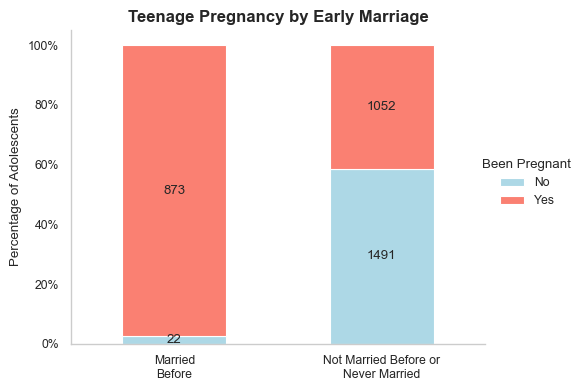

In [17]:
# M0
plot_stacked_proportions(
    df=df,
    category_var='marriage_timing2',
    outcome_var='been_preg',
    order=['before', 'never'],
    category_labels=['Married\nBefore','Not Married Before or\nNever Married'],
    rotate_xticks=0,
    outcome_labels=['No','Yes'],
    legend_title='Been Pregnant',
    title='Teenage Pregnancy by Early Marriage',
    save_path='./results/{title}.png'
)

Note that 'Not married' includes girls that were not married before pregnancy or never married, while married includes all girls that were married before pregnancy or married and never became pregnant.

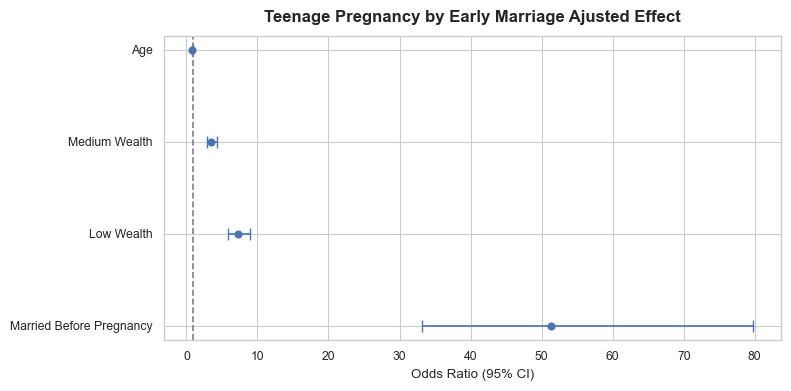

In [19]:
# M1
var_labels = {
    'wealth_Low': 'Low Wealth',
    'wealth_Medium': 'Medium Wealth',
    'age_completed' : 'Age',
    'mt_before' : 'Married Before Pregnancy'
}

plot_significant_forest(
    m1,
    alpha=0.05,
    title="Teenage Pregnancy by Early Marriage Ajusted Effect",
    var_labels=var_labels,
    include_const=False,
    save_path="./results/{title}.png"
)

## 3. Age of First Sexual Encounter and Teenage Pregnancy

**What is the effect of age at sexual debut on teen pregnancy risk?**

**Sample:**  
- Teen pregnancies: 1,830  
- Never pregnant (aged out): 578  
- Post‑teen pregnancies: 229  
- Total at‑risk: 2,637  

**=== M0: Unadjusted Effect ===**  
- **Per‑year delay in debut:** OR = 0.71 (95% CI: exp[–0.417, –0.272] ≈ [0.66, 0.76], p < 0.001)  
- **Pseudo‑R²:** 0.0397 (4% explained)  

> Each year older at first sex reduces the odds of teen pregnancy by about 29%.  

**=== M1: Adjusted Effect ===**  
- **Per‑year delay:** OR = 0.70 (95% CI: [0.65, 0.76], p < 0.001)  
- **Willing first sex:** OR = 1.40 (95% CI: [1.03, 1.91], p = 0.031)  
- **Protective behavior at debut:** OR = 0.40 (95% CI: [0.33, 0.49], p < 0.001)  
- **Partner = husband vs. boyfriend:** OR = 12.75 (95% CI: [6.48, 25.12], p < 0.001)  
- **Partner = other vs. boyfriend:** OR = 0.77 (95% CI: [0.42, 1.47], p = 0.453)  
- **Pseudo‑R²:** 0.1250 (12.5% explained)  

> Even after accounting for consent, protection, and partner type, later sexual debut remains protective (≈ 30% lower odds per year), and first sex with a husband carries a 12‑fold higher risk of teen pregnancy.

In [21]:
# Sample
cond_teen = (
    (df_raw['been_preg'] == 1) &
    (df_raw['age_preg'] <= 19) &
    (df_raw['sex_age'] < 19)
)

cond_never = (
    (df_raw['been_preg'] == 0) &
    (df_raw['sex_age'] < 19) &
    (df_raw['age_completed'] >= 20)
)

cond_postteen = (
    (df_raw['been_preg'] == 1) &
    (df_raw['age_preg'] > 19) &
    (df_raw['sex_age'] < 19)
)

df = df_raw.loc[cond_teen | cond_never | cond_postteen].copy()

# Check you got the right counts
print("Teen pregnancies:",    df[cond_teen].shape[0])
print("Never pregnant:",      df[cond_never].shape[0])
print("Preg after 19:",       df[cond_postteen].shape[0])
print("Total at‐risk sample:", df.shape[0])

# Process features (dropna, create dummies)
df = df.dropna(subset=['been_preg', 'sex_age', 'will_sex_binary', 'person_sex_group', 'do_anything_binary'])
partner_dummies = pd.get_dummies(df['person_sex_group'], prefix='partner', drop_first=True)

# Model
y = df['been_preg'].astype(int)
X0 = pd.DataFrame({'sex_age': df['sex_age'].astype(float)})
X1 = pd.concat([df[['sex_age', 'will_sex_binary', 'do_anything_binary']].astype(float), partner_dummies], axis=1)
m0, m1 = fit_and_summarize_logit(y, X0, X1, 
                                 model_names=("M0: Unadjusted Effect", "M1: Adjusted Effect"))

Teen pregnancies: 1830
Never pregnant: 578
Preg after 19: 229
Total at‐risk sample: 2637
=== M0: Unadjusted Effect ===
                           Logit Regression Results                           
Dep. Variable:              been_preg   No. Observations:                 2464
Model:                          Logit   Df Residuals:                     2462
Method:                           MLE   Df Model:                            1
Date:                Tue, 06 May 2025   Pseudo R-squ.:                 0.03971
Time:                        18:00:09   Log-Likelihood:                -1244.2
converged:                       True   LL-Null:                       -1295.7
Covariance Type:            nonrobust   LLR p-value:                 3.503e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9363      0.617     11.241      0.000       5.727       8.146
sex_age     

### Visualisations

    sex_age  rate    n
0      5.00  0.00    1
1      7.00  1.00    1
2      8.00  0.33    3
3     10.00  0.73   15
4     11.00  0.80   10
5     12.00  0.95   43
6     13.00  0.89   74
7     14.00  0.92  210
8     15.00  0.87  383
9     16.00  0.85  515
10    17.00  0.73  566
11    18.00  0.65  643


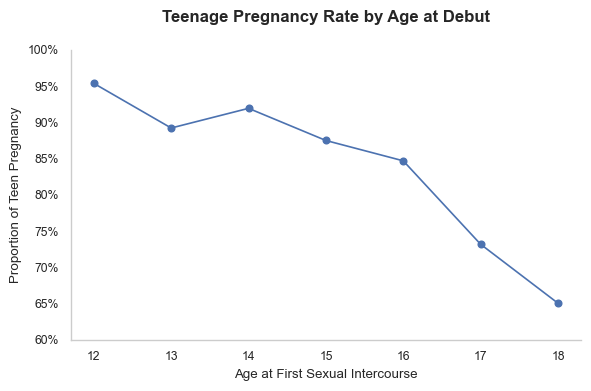

In [23]:
# M0
age_grp = df.groupby('sex_age')['been_preg'] \
            .agg(rate='mean', n='count') \
            .reset_index()

print(age_grp)

# Only keep bins with N > 20
age_grp = age_grp[age_grp['n'] >= 20]

# 3) Plot
plt.figure(figsize=(6,4))
plt.plot(age_grp['sex_age'], age_grp['rate'], marker='o', linestyle='-')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.ylim(0.6, 1)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel("Age at First Sexual Intercourse")
plt.ylabel("Proportion of Teen Pregnancy")
plt.title("Teenage Pregnancy Rate by Age at Debut", fontweight='bold', fontsize=12, pad=20)
plt.grid(False)
plt.tight_layout()
plt.savefig("./results/Teenage_Pregnancy_Rate_by_Age_at_Debut", dpi=300)
plt.show()

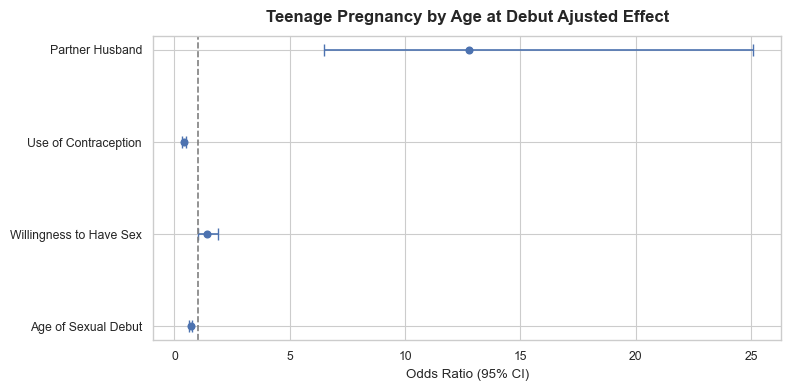

In [24]:
# M1
var_labels = {
    'partner_husband': 'Partner Husband',
    'do_anything_binary': 'Use of Contraception',
    'will_sex_binary' : 'Willingness to Have Sex',
    'sex_age' : 'Age of Sexual Debut'
}

plot_significant_forest(
    m1,
    alpha=0.05,
    title="Teenage Pregnancy by Age at Debut Ajusted Effect",
    var_labels=var_labels,
    include_const=False,
    save_path="./results/{title}.png"
)

## 4. Sexual Partner at First Encounter and Pregnancy

**Does the type of first sexual partner affect teen pregnancy risk?**

**Sample:** same at‑risk sample as above (n = 2,464)

**=== M0: Unadjusted Effect ===**  
- **Boyfriend vs. husband (ref):** OR = 0.08 (95% CI: [0.04, 0.16], p < 0.001)  
- **Other vs. husband:** OR = 0.11 (95% CI: [0.04, 0.26], p < 0.001)  
- **Pseudo‑R²:** 0.0452 (4.5% explained)  

> Adolescents whose first sexual partner was a boyfriend had about a 92% lower odds of teen pregnancy (OR = 0.08), and those whose first partner was classified as “other” had about an 89% lower odds (OR = 0.11), compared with girls whose first partner was their husband.

**=== M1: Adjusted Effect ===**  
- **Boyfriend vs. husband:** OR = 0.08 (95% CI: [0.04, 0.16], p < 0.001)  
- **Other vs. husband:** OR = 0.06 (95% CI: [0.02, 0.15], p < 0.001)  
- **Sex age, willingness, protection** also in the model  
- **Pseudo‑R²:** 0.1250 (12.5% explained)  

> Even after controlling for age at debut, consent, and protection, partnering with a boyfriend or other non‐spouse at first sex is associated with dramatically lower odds of teen pregnancy compared to spousal debut.

In [26]:
# Sample
cond_teen = (
    (df_raw['been_preg'] == 1) &
    (df_raw['age_preg'] <= 19) &
    (df_raw['sex_age'] < 19)
)

cond_never = (
    (df_raw['been_preg'] == 0) &
    (df_raw['sex_age'] < 19) &
    (df_raw['age_completed'] >= 20)
)

cond_postteen = (
    (df_raw['been_preg'] == 1) &
    (df_raw['age_preg'] > 19) &
    (df_raw['sex_age'] < 19)
)

df = df_raw.loc[cond_teen | cond_never | cond_postteen].copy()

# Check you got the right counts
print("Teen pregnancies:",    df[cond_teen].shape[0])
print("Never pregnant:",      df[cond_never].shape[0])
print("Preg after 19:",       df[cond_postteen].shape[0])
print("Total at‐risk sample:", df.shape[0])

# Process features (dropna, create dummies)
df = df.dropna(subset=['been_preg', 'will_sex_binary', 'person_sex_group', 'do_anything_binary'])
df['person_sex_group'] = pd.Categorical(df['person_sex_group'], categories=['husband', 'boyfriend', 'other'], ordered=False)
partner_dummies = pd.get_dummies(df['person_sex_group'], prefix='partner', drop_first=True)

# Model
y = df['been_preg'].astype(int)
X0 = partner_dummies
X1 = pd.concat([df[['sex_age', 'will_sex_binary', 'do_anything_binary']].astype(float), partner_dummies], axis=1)
m0, m1 = fit_and_summarize_logit(y, X0, X1, 
                                 model_names=("M0: Unadjusted Effect", "M1: Adjusted Effect"))

Teen pregnancies: 1830
Never pregnant: 578
Preg after 19: 229
Total at‐risk sample: 2637
=== M0: Unadjusted Effect ===
                           Logit Regression Results                           
Dep. Variable:              been_preg   No. Observations:                 2464
Model:                          Logit   Df Residuals:                     2461
Method:                           MLE   Df Model:                            2
Date:                Tue, 06 May 2025   Pseudo R-squ.:                 0.04516
Time:                        18:00:10   Log-Likelihood:                -1237.2
converged:                       True   LL-Null:                       -1295.7
Covariance Type:            nonrobust   LLR p-value:                 3.901e-26
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.5866      0.338     10.614      0.000       2.924    

### Visualisations

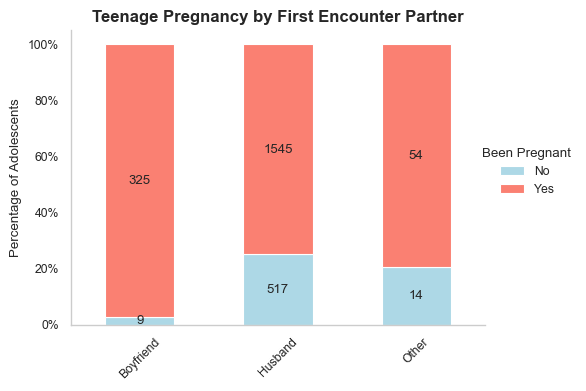

In [28]:
# M0
plot_stacked_proportions(
    df=df,
    category_var='person_sex_group',
    outcome_var='been_preg',
    order=['husband', 'boyfriend','other'],
    category_labels=['Boyfriend','Husband','Other'],
    outcome_labels=['No','Yes'],
    title='Teenage Pregnancy by First Encounter Partner',
    legend_title='Been Pregnant',
    rotate_xticks=45,
    save_path='./results/{title}.png'
)

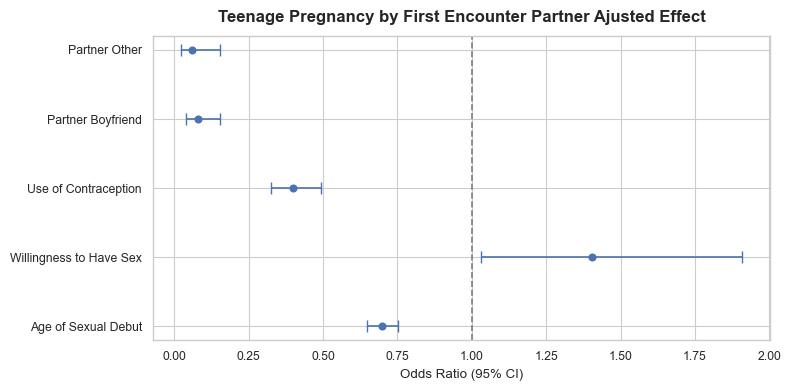

In [29]:
# M1
var_labels = {
    'partner_other': 'Partner Other',
    'partner_boyfriend': 'Partner Boyfriend',
    'do_anything_binary': 'Use of Contraception',
    'will_sex_binary' : 'Willingness to Have Sex',
    'sex_age' : 'Age of Sexual Debut'
}

plot_significant_forest(
    m1,
    alpha=0.05,
    title="Teenage Pregnancy by First Encounter Partner Ajusted Effect",
    var_labels=var_labels,
    include_const=False,
    save_path="./results/{title}.png"
)

## 5. Condom Use and Teenage Pregnancy

**Does consistent condom use reduce teen pregnancy risk?**

**Sample:**
- Cases: Girls who experienced pregnancy between ages 10–19 = 629
- Controls: Girls who never got pregnant but were sexually active before 19 years = 1,165  

**=== M0: Unadjusted Effect ===**  
- **Always use condoms vs. sometimes/never:** OR = 0.27 (95% CI: exp[–1.778, –0.859] ≈ [0.17, 0.42], p < 0.001)  
- **Pseudo‑R²:** 0.0595 (6% explained)  

> Girls who consistently use condoms have about 73% lower odds of teen pregnancy.  

**=== M1: Adjusted Effect ===**  
- **Always use condoms:** OR = 0.37 (95% CI: [0.23, 0.60], p < 0.001)  
- **Protection at debut:** OR = 0.18 (95% CI: [0.11, 0.29], p < 0.001)  
- **Concern about pregnancy (reverse‐coded):** OR = 0.78 (95% CI: [0.63, 0.95], p = 0.013)  
- **Pseudo‑R²:** 0.1571 (15.7% explained)  

> Even after accounting for other protective behaviors at debut and pregnancy concerns, consistent condom use remains strongly protective (≈ 63% lower odds).

In [31]:
# Sample
df = df_raw[(df_raw['life_sex'] == 1) & (df_raw['age_completed'] <= 19)].copy()

# Create a binary variable for sustained condom use (some_times_binary): 1 if Always, 0 if not.
df['some_times_binary'] = np.where(df['some_times'] == 3, 1, 0)

# Process features (dropna, create dummies)
df = df.dropna(subset=['been_preg', 'some_times_binary', 'do_anything_binary', 'worry_preg_reverse'])
df['person_sex_group'] = pd.Categorical(df['person_sex_group'], categories=['husband', 'boyfriend', 'other'], ordered=False)

# Model
y = df['been_preg'].astype(int)
X0 = pd.DataFrame({'some_times_binary': df['some_times_binary'].astype(float)})
X1 = df[['some_times_binary', 'do_anything_binary', 'worry_preg_reverse']].astype(int)
m0, m1 = fit_and_summarize_logit(y, X0, X1, 
                                 model_names=("M0: Unadjusted Effect", "M1: Adjusted Effect"))

=== M0: Unadjusted Effect ===
                           Logit Regression Results                           
Dep. Variable:              been_preg   No. Observations:                  669
Model:                          Logit   Df Residuals:                      667
Method:                           MLE   Df Model:                            1
Date:                Tue, 06 May 2025   Pseudo R-squ.:                 0.05949
Time:                        18:00:10   Log-Likelihood:                -284.25
converged:                       True   LL-Null:                       -302.23
Covariance Type:            nonrobust   LLR p-value:                 2.016e-09
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.0826      0.126     -8.576      0.000      -1.330      -0.835
some_times_binary    -1.3185      0.234     -5.628      0.000      -1.778      -

### Visualisations

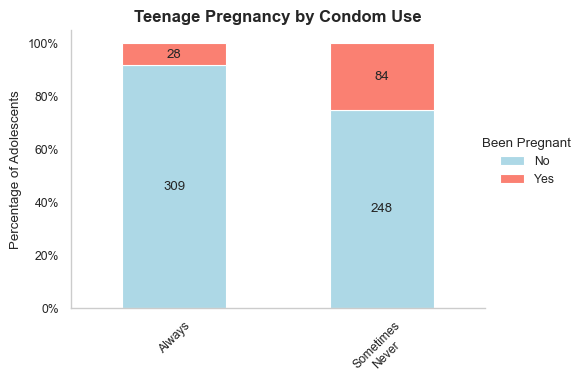

In [33]:
# M0
plot_stacked_proportions(
    df=df,
    category_var='some_times_binary',
    outcome_var='been_preg',
    order=[1, 0],
    category_labels=['Always','Sometimes\nNever'],
    outcome_labels=['No','Yes'],
    title='Teenage Pregnancy by Condom Use',
    legend_title='Been Pregnant',
    rotate_xticks=45,
    save_path='./results/{title}.png'
)

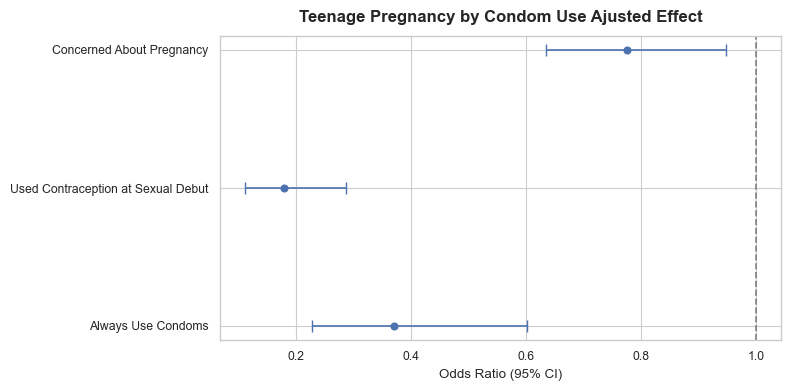

In [34]:
# M1
var_labels = {
    'worry_preg_reverse': 'Concerned About Pregnancy',
    'do_anything_binary': 'Used Contraception at Sexual Debut',
    'some_times_binary' : 'Always Use Condoms',
}

plot_significant_forest(
    m1,
    alpha=0.05,
    title="Teenage Pregnancy by Condom Use Ajusted Effect",
    var_labels=var_labels,
    include_const=False,
    save_path="./results/{title}.png"
)

## 6. Teenage Pregnancy and School Dropout

**Does teenage pregnancy increase school dropout risk?**

**Sample:** Girls ≤ 19 years (n = 4,845)  
- Still in school: 4,358  
- Dropped out: 487  

**=== M0: Unadjusted Effect ===**  
- **Low vs. High wealth:** OR = 5.06 (95% CI: [4.10, 6.74], p < 0.001)  
- **Medium vs. High wealth:** OR = 2.68 (95% CI: [1.99, 3.60], p < 0.001)  
- **Pseudo‑R²:** 0.0498 (5.0% explained)  

> Low‑wealth girls have 5 times the odds of dropping out compared to high‑wealth peers; medium‑wealth girls have about 2.7 times the odds.  

**=== M1: Adjusted Effect ===**  
- **Low vs. High wealth:** OR = 5.08 (95% CI: [4.18, 6.68], p < 0.001)  
- **Medium vs. High wealth:** OR = 2.70 (95% CI: [2.00, 3.60], p < 0.001)  
- **Age (per year):** OR = 0.97 (95% CI: [0.94, 1.01], p = 0.138)  
- **Ever married vs. never:** OR = 0.88 (95% CI: [0.63, 1.24], p = 0.466)  
- **Pseudo‑R²:** 0.0509 (5.1% explained)  

> After adjusting for age and marital status, the wealth gradient in school dropout remains virtually unchanged, and neither age nor marriage status is a significant predictor of dropout.

In [36]:
# Sample
df = df_raw[df_raw['age_completed'] <= 19].copy()

# Process features (dropna, create dummies)
df = df.dropna(subset=['been_preg', 'dropped_out', 'age_completed', 'been_married_binary'])
wealth_dummies = pd.get_dummies(df['wealth_tertile'], prefix='wealth', drop_first=True)

# Model
y = df['dropped_out']
X0 = wealth_dummies
X1 = pd.concat([wealth_dummies, df[['age_completed','been_married_binary']]], axis=1)
m0, m1 = fit_and_summarize_logit(y, X0, X1, 
                                 model_names=("M0: Unadjusted Effect", "M1: Adjusted Effect"))

=== M0: Unadjusted Effect ===
                           Logit Regression Results                           
Dep. Variable:            dropped_out   No. Observations:                 4845
Model:                          Logit   Df Residuals:                     4842
Method:                           MLE   Df Model:                            2
Date:                Tue, 06 May 2025   Pseudo R-squ.:                 0.04983
Time:                        18:00:11   Log-Likelihood:                -1501.8
converged:                       True   LL-Null:                       -1580.5
Covariance Type:            nonrobust   LLR p-value:                 6.256e-35
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.2088      0.128    -25.167      0.000      -3.459      -2.959
wealth_Low        1.6211      0.144     11.221      0.000       1.338       1.904
wealth_Med

### Visualisatons

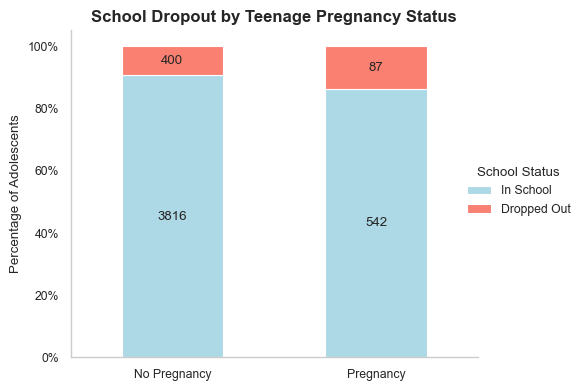

In [38]:
# M0
plot_stacked_proportions(
    df=df,
    category_var='been_preg',
    outcome_var='dropped_out',
    order=[0,1],
    category_labels=['No Pregnancy', 'Pregnancy'],
    rotate_xticks=0,
    outcome_labels=["In School", "Dropped Out"],
    legend_title='School Status',
    title='School Dropout by Teenage Pregnancy Status',
    save_path='./results/{title}.png'
)

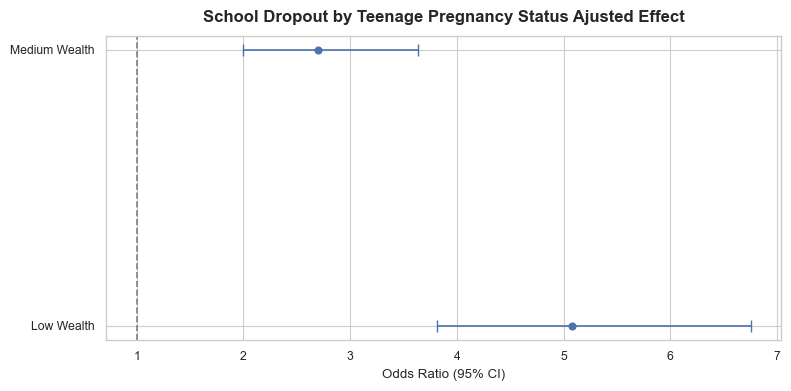

In [39]:
# M1
var_labels = {
    'wealth_Low': 'Low Wealth',
    'wealth_Medium': 'Medium Wealth',
}

plot_significant_forest(
    m1,
    alpha=0.05,
    title="School Dropout by Teenage Pregnancy Status Ajusted Effect",
    var_labels=var_labels,
    include_const=False,
    save_path="./results/{title}.png"
)